✍ Давайте закрепим навыки работы с деревьями, решив реальную задачу из практического кейса.

Начнём немного издалека. Представьте, что вы общаетесь с незнакомым человеком по телефону или сидя к нему спиной. Сможете ли вы по нескольким фразам понять, какого пола ваш собеседник? В большинстве случаев это будет лёгкой задачей. Но задумывались ли вы, как ваш мозг определяет пол человека по голосу?

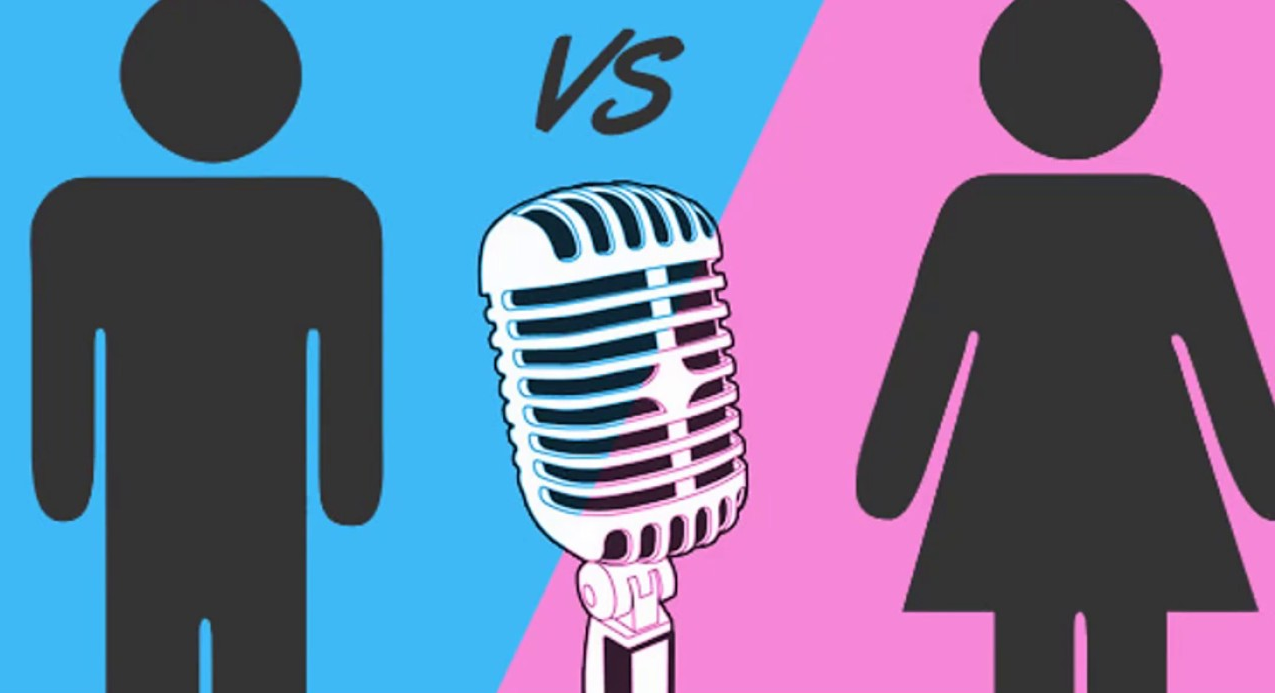

Всё очень просто: женские и мужские голоса заметно различаются по акустическим свойствам. Есть существенные физиологические различия, подтверждённые научно и активно используемые как в общественной жизни, так и технических устройствах. Они обусловлены небольшими различиями в строении речевого аппарата мужчины и женщины, которые формируются с возрастом. Эти различия проявляются в частотах звука, тембре и громкости.

Поэтому когда вы слышите незнакомый голос, ваш мозг на основе его акустических свойств и уже заранее заготовленных паттернов в вашей памяти определяет пол человека.

### Почему бы нам не обучить модель машинного обучения классифицировать людей на мужчин и женщин по их голосу? Системе идентификации пола по голосу, основанной на такой модели, можно найти применение во многих областях — от маркетинга до интегрирования в системы безопасности.

На Kaggle можно найти множество датасетов для решения этой задачи. Большинство из них состоят из больших массивов размеченных аудиофайлов, обработку которых составители датасетов возлагают на исследователей.

Мы пока что не умеем работать с аудиоинформацией и преобразовывать её в привычный нам формат табличных данных, поэтому для решения данной задачи мы нашли готовый датасет, в котором все преобразования аудиоинформации в числовой табличный формат уже произведены.

Набор данных состоит из 3 168 записанных образцов голоса мужчин и женщин. Образцы предварительно обрабатываются с помощью акустического анализа на языке программирования R с использованием специальных библиотек в диапазоне частот 0 Гц-280 Гц (диапазон человеческого голоса). Если вкратце, в результате обработки звук на аудиозаписи оцифровывается и преобразуется в числовую последовательность частот, из которой извлекаются различные статистические характеристики, например средняя частота, с которой говорит спикер на аудиозаписи, или частота с наибольшей энергией и так далее.

### В столбцах таблицы содержатся статические характеристики для каждой из аудиозаписей, вычисленные на основе акустических свойств.

### Здесь стоит сделать **важное лирическое отступление**.

Очень часто Data Scientist сталкивается с задачами, которые находятся за гранью области его компетенций. Типичный пример — медицинские задачи. Дата-сайентист может не разбираться в том, как получаются те или иные медицинские показатели, в чём они измеряются и какая у них норма, ведь это зона компетенций врача. Однако это же не повод не решать поставленную задачу (хотя, конечно же, базовое понимание внутренней кухни в большинстве случаев даёт определённый бонус).

Мы сейчас как раз рассматриваем пример подобного рода — нам интересен не столько процесс извлечения данных из каждой аудиозаписи, сколько сам результат.

Наша цель как специалистов в Data Science состоит в построении модели распознавания пола по уже обработанным аудиозаписям, а не в проектировании процесса их обработки. То есть в процессе решения задачи вы вполне можете абстрагироваться от непосредственного значения самих признаков и воспринимать их в математическом ключе как векторы $x_1, x_2,...,x_M$.

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB

Итак, приступаем к работе. Прочитаем наши данные:

In [2]:
voice_data = pd.read_csv('data/voice_gender.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [3]:
voice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

Итак, все признаки, за исключением целевого, кодируются числовым форматом. Типизация целевой переменной не имеет значения для моделей машинного обучения в библиотеке sklearn, поэтому кодирование категориальных признаков нам не потребуется.

Заодно проверим данные на наличие пропусков:

In [4]:
voice_data.isnull().sum().sum()

0

Общее количество пропусков в датасете равно 0. Значит, обработка пропущенных значений нам не потребуется.

→ При желании вы можете провести разведывательный анализ и изучить взаимосвязи между признаками, описывающими голос на аудиозаписи, и целевой переменной, чтобы предварительно определить наиболее значимые признаки и их влияние.

Мы же пропустим этот шаг и перейдём к формированию обучающей и тестовой выборок. Разделим датасет на две части в соотношении 80/20:

In [5]:
# Формируем обучающую и тестовую выборки
X = voice_data.drop("label", axis=1)
y = voice_data["label"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2534, 20)
Test shape: (634, 20)


Дополнительная предобработка данных нам не потребуется, поэтому мы можем смело перейти к построению моделей. Для моделирования мы, конечно же, будем использовать модели «древесного» типа.

## Задание 7.1

Начнём с решающего пня.

Создайте модель дерева решений максимальной глубины 1. В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.

1. На основе какого фактора будет построено решающее правило в корневой вершине?
2. Чему равно оптимальное пороговое значение для данного фактора? Ответ округлите до трёх знаков после точки-разделителя.
3. Сколько процентов наблюдений, для которых выполняется заданное в корневой вершине условие, содержится в обучающей выборке? Ответ округлите до одного знака после точки-разделителя. Не указывайте в ответе символ %.
4. Сделайте предсказание и рассчитайте значение метрики accuracy на тестовой выборке. Ответ округлите до трёх знаков после точки-разделителя.

Accuracy: 0.956


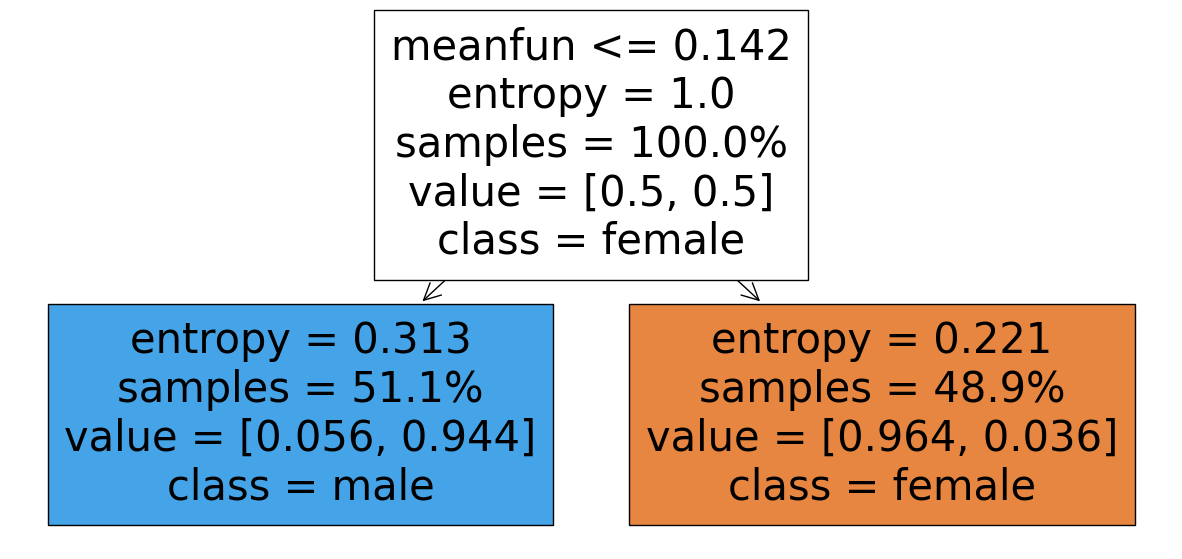

In [6]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy' #критерий информативности
)
dt.fit(X_train, y_train)

# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    class_names=dt.classes_, #имена классов
);
# Делаем предсказание
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на тестовой выборке
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

## Задание 7.2

Увеличим глубину дерева.

Создайте дерево решений с максимальной глубиной 2. В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.

1. Из приведённых ниже факторов выберите те, что используются при построении данного дерева решений:
2. Сколько листьев в построенном дереве содержат в качестве предсказания класс female? Для того, чтобы отобразить имена классов при визуализации дерева решения с помощью функции plot_tree(), укажите параметр class_names=dt.classes_.
3. Сделайте предсказание и рассчитайте значение метрики accuracy на тестовой выборке. Ответ округлите до трёх знаков после точки-разделителя.

Accuracy: 0.962


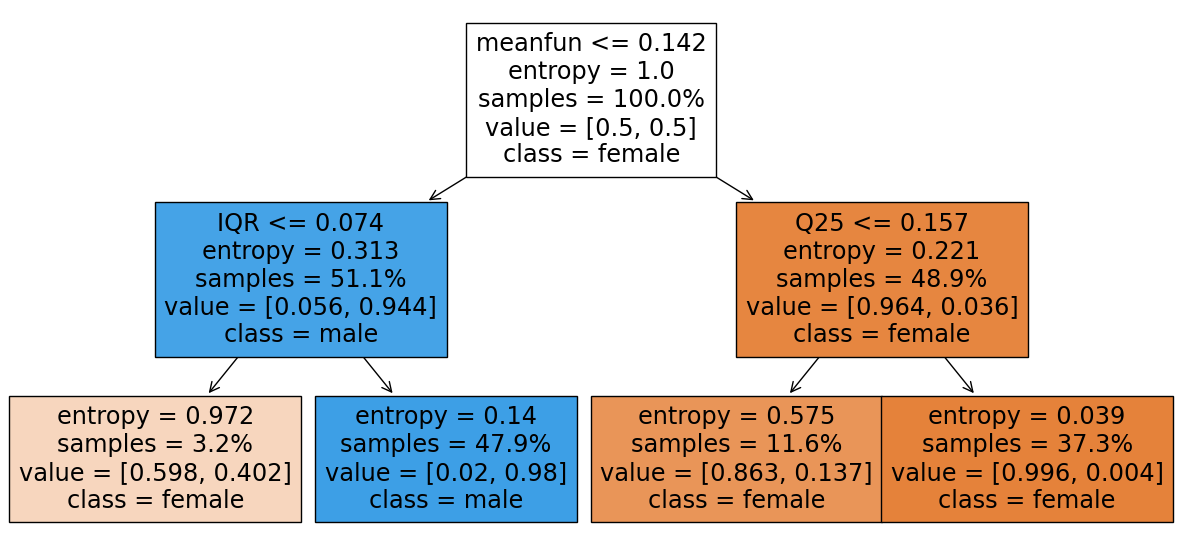

In [7]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=2, #глубина
    criterion='entropy', #критерий информативности
    random_state=42
)
dt.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    class_names=dt.classes_, #имена классов
);
# Делаем предсказание
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на тестовой выборке
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

## Задание 7.3

Давайте дадим дереву решений полную свободу.

Создайте дерево решений, не ограничивая его максимальную глубину. В качестве критерия информативности используйте энтропию Шеннона.

В качестве значения параметра random_state возьмите 0.

Обучите модель на тренировочной выборке.

1. Чему равна глубина полученного дерева решения? Напомним, что глубину дерева можно узнать с помощью метода get_depth().
2. Чему равно количество листьев в полученном дереве решений? Напомним, что количество листьев можно узнать с помощью метода get_n_leaves().
3. Сделайте предсказание для обучающей и тестовой выборок и рассчитайте значение метрики accuracy на каждой из выборок. Ответы округлите до трёх знаков после точки-разделителя.

In [8]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X_train, y_train)
print('Depth: {}'.format(dt.get_depth()))
print('Count of leaves: {}'.format(dt.get_n_leaves()))
# Делаем предсказание
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на обучающей и тестовой выборках
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Depth: 12
Count of leaves: 54
Train accuracy: 1.000
Test accuracy: 0.973


## Задание 7.4

Давайте попробуем найти оптимальные внешние параметры модели дерева решений для поставленной задачи. Воспользуемся классическим методом подбора гиперпараметров — перебором на сетке с кросс-валидацией (Grid SearchCV).

В качестве кросс-валидатора будем использовать k-fold-валидатор со стратификацией (StratifiedKFold):

С помощью Grid SearchCV из модуля model_selection библиотеки sklearn переберите гиперпараметры дерева решений из приведённой сетки на обучающей выборке и найдите оптимальные. Параметр random_state для дерева решений установите равным 0. В качестве метрики качества (параметр scoring) используйте accuracy.

1. Какой критерий информативности использует наилучшая модель?
2. Чему равна оптимальная максимальная глубина?
3. Чему равно оптимальное минимальное количество объектов, необходимое для разбиения?
4. С помощью наилучшей модели сделайте предсказание для обучающей и тестовой выборок. Рассчитайте значение метрики accuracy на каждой из выборок. Ответы округлите до трёх знаков после точки-разделителя.

In [9]:
# Задаем сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'], #критерий информативности
    'max_depth': [4, 5, 6, 7, 8, 9, 10], #максимальная глубина дерева
    'min_samples_split': [3, 4, 5, 10] #минимальное количество объектов, необходимое для сплита
}

# Задаем метод кросс-валидации
cv = model_selection.StratifiedKFold(n_splits=5)

# Инициализируем поиск на сетке и обучаем его
gs = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=0), #модель
    param_grid=param_grid, #сетка параметров
    scoring='accuracy', #метрика
    cv=cv, #кросс-валидатор
    n_jobs=-1 #используем все мощности процессора
)
gs.fit(X_train, y_train)
print(gs.best_params_)
# Определяем наилучшую модель
best_tree = gs.best_estimator_

# Делаем предсказание
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)
# Считаем метрику accuracy на обучающей и тестовой выборках
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}
Train accuracy: 0.996
Test accuracy: 0.970


## Задание 7.5

Для оптимального дерева решений, построенного в задании 7.4, найдите важность каждого из факторов. Визуализируйте её в виде столбчатой диаграммы.

Выделите топ-3 наиболее важных факторов, участвующих в построении дерева решений:

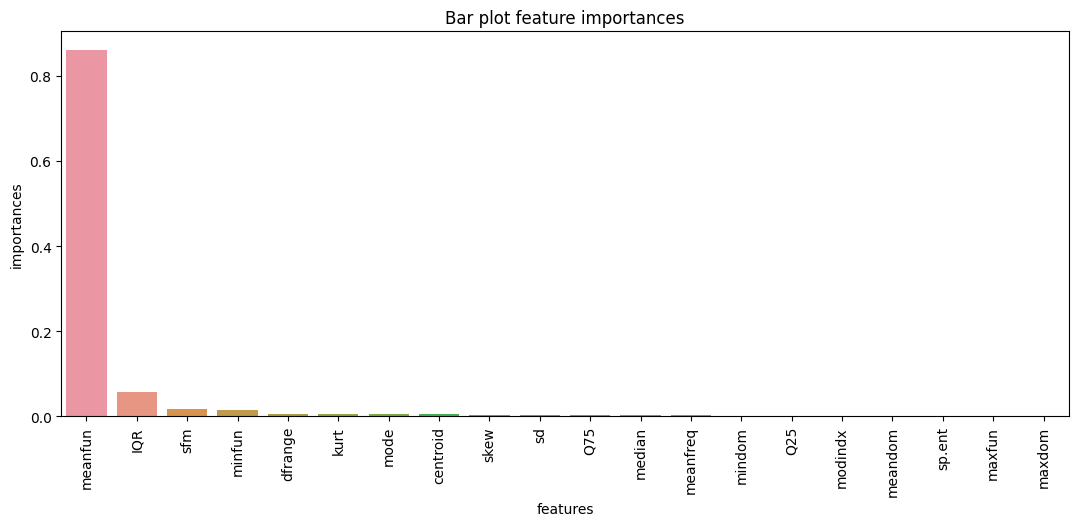

In [10]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
features = X.columns #признаки
feature_importances = best_tree.feature_importances_ #важность признаков
# Создаём DataFrame, содержащий информацию о важности признаков
importances_data = pd.DataFrame({'features': features, 'importances': feature_importances})
importances_data = importances_data.sort_values(by='importances', ascending=False)
# Строим столбчатую диаграмму
sns.barplot(data=importances_data, x='features', y='importances', ax=ax);
# Добавляем подпись к графику и поворот меток на оси абсцисс
ax.set_title('Bar plot feature importances')
ax.xaxis.set_tick_params(rotation=90)